In [95]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

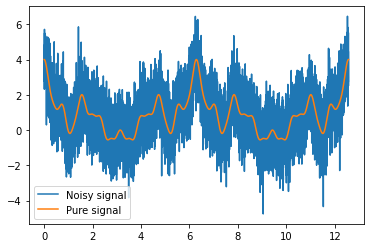

In [96]:
N = 10_000
steps = 4

time = np.linspace(0,4*np.pi,N)
signal = np.zeros(N)
for j in range(steps):
  signal = signal + np.cos((j + 1) * time) ** (j + 1)

noisy = signal + np.random.randn(N)

plt.plot(time,noisy,time,signal)
plt.legend(['Noisy signal', 'Pure signal'])
plt.show()

In [97]:
class RunningMeanNoiseRemover:
  def __init__(self, timeseries, range):
    self.range = range
    self.timeseries = timeseries
  
  def denoise(self):
    N = len(self.timeseries)
    result = np.zeros(N)
    for i in range(N):
      result[i] = np.mean(self.timeseries[self.startOfInterval(i) : self.endOfInterval(i)])
    return result
      
  def startOfInterval(self,index):
    min = index - self.range
    return min if min > 0 else 0
  
  def endOfInterval(self,index):
    max = index + self.range
    return max if max < len(self.timeseries) else len(self.timeseries)

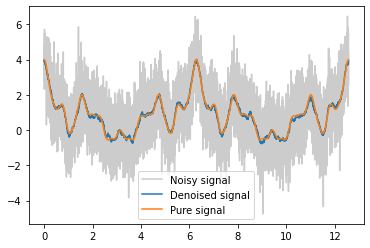

In [98]:
denoisedSignal = RunningMeanNoiseRemover(noisy, 50).denoise()

plt.plot(time,noisy,color=[.8,.8,.8])
plt.plot(time,denoisedSignal)
plt.plot(time,signal)

plt.legend(['Noisy signal', 'Denoised signal', 'Pure signal'])
plt.show()

In [99]:
stepSize = 100
deviation = np.zeros(N//stepSize)
for i in range(N//stepSize):
  denoisedSignal = RunningMeanNoiseRemover(noisy, i * stepSize).denoise()
  deviation[i] = np.sum(np.abs(signal - denoisedSignal))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


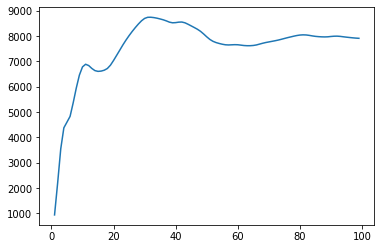

In [100]:
plt.plot(deviation)

In [101]:
denoisedSignal = RunningMeanNoiseRemover(noisy, 50).denoise()

In [102]:
kvals = np.arange(5,41)
signalCorrelation = []
for i in kvals:
  fsig = RunningMeanNoiseRemover(noisy,i).denoise()
  signalCorrelation.append(np.corrcoef(fsig,signal)[0,1])

signalCorrelation = np.array(signalCorrelation)

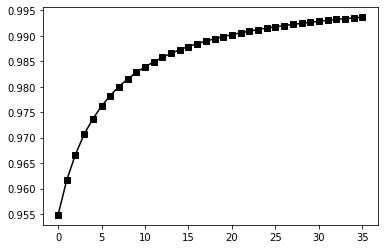

In [103]:
plt.plot(signalCorrelation,'ks-')
plt.show()

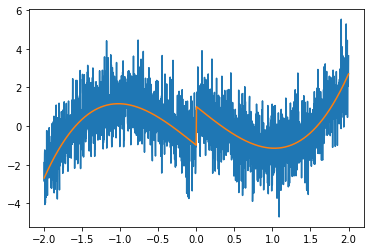

In [104]:
from scipy.signal import detrend

srate = 512
time = np.arange(-2,2+1/srate,1/srate)
nPoints = len(time)
signal = detrend(time**3 + np.sign(time))
noisySignal = signal + np.random.randn(nPoints) * 1.1
plt.plot(time,noisySignal,time,signal)
plt.show()

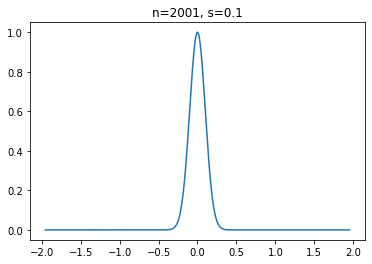

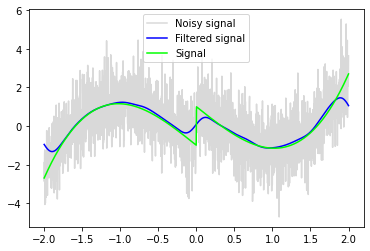

In [105]:
# create the gaussian
k = 1000
x = np.arange(-k,k+1)/srate
s = .1

gkern = np.exp( -x**2 / (2*s**2) )
plt.plot(x, gkern)
plt.title('n=%s, s=%g'%(2*k+1, s))
plt.show()

gkern = gkern / sum(gkern)
filteredSignal = np.convolve(noisySignal,gkern,mode='same')

plt.plot(time,noisySignal,color=[.85,.85,.85])
plt.plot(time,filteredSignal,color=[0,0,1])
plt.plot(time,signal,color=[0,1,0])
plt.legend(['Noisy signal', 'Filtered signal', 'Signal'])
plt.show()

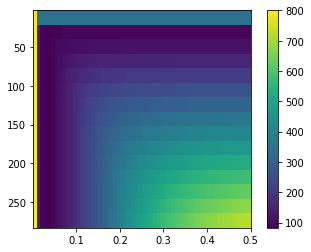

In [106]:
krange = np.arange(3,300,20)
srange = np.linspace(.001,.5,60)
sseMatrix = np.zeros( shape=( len(krange), len(srange) ) )

for i in range(len(krange)):
  for j in range(len(srange)):
    ki = krange[i]
    si = srange[j]

    x = np.arange(-ki,ki+1)/srate
    gkern = np.exp( (-(x**2)) / (2*si**2) )
    gkern = gkern / sum(gkern)
    filteredSignal = np.convolve(noisySignal,gkern,mode='same')
    SSE = np.sum( (filteredSignal - signal) ** 2 )
    sseMatrix[i,j] = SSE

plt.imshow(sseMatrix,extent=[srange[0],srange[-1],krange[-1],krange[0]],vmax=800)
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.colorbar()
plt.show()

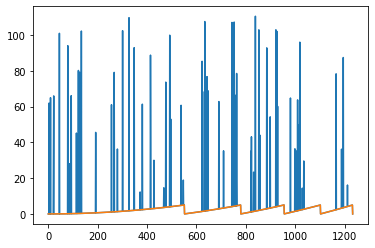

In [107]:
N = 1234
t = np.linspace(0,5,N)
signal = t**2 % 5
noise = ((np.random.random(N) < .05) + (np.zeros(N))) * (np.random.randint(100,size=N) + 10)
noisySignal = signal + noise
plt.plot(noisySignal)
plt.plot(signal)
plt.show()

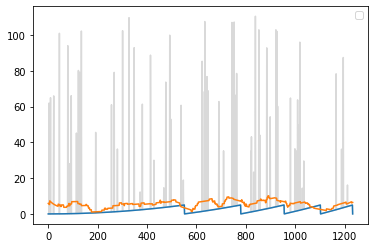

In [108]:
# attempting to denoise with running mean
denoised = RunningMeanNoiseRemover(noisySignal, 40).denoise()
plt.plot(noisySignal, color=[0.85,0.85,0.85])
plt.plot(signal)
plt.plot(denoised)
plt.legend()
plt.show()

In [109]:
import copy

class MedianNoiseRemover:
  def __init__(self,timeseries,threshold,k):
    self.ts = copy.deepcopy(timeseries)
    self.threshold = threshold
    self.k = k
  
  def denoise(self):
    indexes = np.where(self.ts > threshold)
    for index in indexes[0]:
      self.denoiseAtIndex(index)
    return self.ts

  def startIndex(self,i):
    return np.max([i-k,0])
  
  def endIndex(self,i):
    return np.min([i+k,len(self.ts)])
  
  def denoiseAtIndex(self,index):
    start = self.startIndex(index)
    end = self.endIndex(index)
    newValue = np.median(self.ts[start : end])
    self.ts[index] = newValue


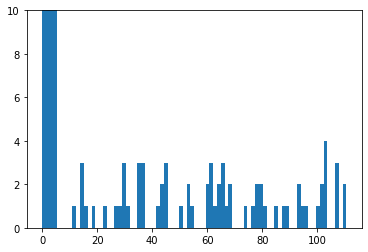

In [110]:
# median denoising
# define a threshold for spikes
plt.hist(noisySignal, 80)
plt.ylim([0, 10])
plt.show()

# If a value is larger than the threshold, we replace it with median of surrounding N points

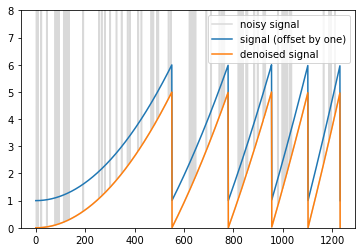

In [131]:
threshold = 7
k = 7
denoisedSignal = MedianNoiseRemover(noisySignal,threshold,k).denoise()

plt.plot(noisySignal,color=[.85,.85,.85])
plt.plot(signal + 1)
plt.plot(denoisedSignal)
plt.ylim([0,8])
plt.legend(['noisy signal','signal (offset by one)', 'denoised signal'])
plt.show()

array([0.00000000e+00, 1.64442419e-05, 6.57769674e-05, ...,
       4.91896278e+00, 4.95946494e+00, 0.00000000e+00])